In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np 
import functools
from tqdm import tqdm
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt

from utility_funs import *
from utility_classes import *
from select_model import *
from prepare_dataset import myDataset

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
## Euler-Maruyama sampler
def Euler_Maruyama_sampler(score_model,
                           x_dim,
                           y,
                           guidance_scale,
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=8, 
                           num_steps=1000, 
                           device='cpu', 
                           eps=1e-3):
    y = torch.tensor(y, device=device, dtype=torch.float32)
    t = torch.ones(batch_size, device=device)
    init_x = generate_filtered_tensor(batch_size, x_dim, device)
#     init_x = torch.randn(batch_size, 1, x_dim, device=device)
#     * marginal_prob_std(t)[:, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
#         for time_step in time_steps:  
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            
            # unconditioned score
            dummy_y = torch.ones_like(y, device=device) * 10  # Dummy value for y
            unconditioned_score = score_model(x, dummy_y, batch_time_step)
            
            # conditioned score
            conditioned_score = score_model(x, y, batch_time_step)
            
            # combine scores using the guidance scale
            score = (1 + guidance_scale) * conditioned_score - guidance_scale * unconditioned_score
            
            mean_x = x + (g**2)[:, None, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None] * torch.randn_like(x)      
            # not include any noise in the last sampling step.
    return mean_x

In [4]:
# ## Prediction Correction sampler
# def pc_sampler(score_model, 
#                x_dim,
#                y,
#                guidance_scale,
#                marginal_prob_std,
#                diffusion_coeff,
#                batch_size, 
#                num_steps, 
#                snr,                
#                device='cuda',
#                eps=1e-3): 
#     y = torch.tensor(y, device=device, dtype=torch.float32)
#     t = torch.ones(batch_size, device=device)
#     init_x = generate_filtered_tensor(batch_size, x_dim, device)
#     time_steps = torch.linspace(1., eps, num_steps, device=device)
#     step_size = time_steps[0] - time_steps[1]
#     x = init_x
#     with torch.no_grad():
#         for time_step in tqdm(time_steps):      
#             batch_time_step = torch.ones(batch_size, device=device) * time_step
            
#             ## Langevin MCMC
#             # unconditioned score
#             dummy_y = torch.ones_like(y, device=device) * 10  # Dummy value for y
#             unconditioned_score = score_model(x, dummy_y, batch_time_step)
            
#             # conditioned score
#             conditioned_score = score_model(x, y, batch_time_step)
            
#             # combine scores using the guidance scale
#             score = (1 + guidance_scale) * conditioned_score - guidance_scale * unconditioned_score
            
#             grad = score
#             grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
#             noise_norm = np.sqrt(np.prod(x.shape[1:]))
#             langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
#             x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

#             ## Euler-Maruyama
#             g = diffusion_coeff(batch_time_step)
            
#             mean_x = x + (g**2)[:, None, None] * score * step_size
#             x = mean_x + torch.sqrt(g**2 * step_size)[:, None, None] * torch.randn_like(x)      
#     return mean_x


In [5]:
# ## ODE sampler
# from scipy import integrate
 
# ## The error tolerance for the black-box ODE solver
# error_tolerance = 1e-5
# def ode_sampler(score_model,
#                 x_dim,
#                 condition,
#                 guidance_scale,
#                 marginal_prob_std,
#                 diffusion_coeff,
#                 batch_size=64, 
#                 atol=error_tolerance, 
#                 rtol=error_tolerance, 
#                 device='cuda', 
#                 z=None,
#                 eps=1e-3):

#     condition = torch.tensor(condition, device=device, dtype=torch.float32)
#     t = torch.ones(batch_size, device=device)
#     # Create the latent code
#     if z is None:
#         init_x = generate_filtered_tensor(batch_size, x_dim, device)
#         # init_x = torch.randn(batch_size, 1, x_dim, device=device) \
#         # * marginal_prob_std(t)[:, None, None]
#     else:
#         init_x = z

#     shape = init_x.shape

#     def score_eval_wrapper(sample, condition, time_steps):
#     # A wrapper of the score-based model for use by the ODE solver.
#         sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
#         time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
#         with torch.no_grad():    
#             # unconditioned score
#             dummy_condition = torch.ones_like(condition) * 10  # Dummy value for y
#             unconditioned_score = score_model(sample, dummy_condition, time_steps)
            
#             # conditioned score
#             conditioned_score = score_model(sample, condition, time_steps)
            
#             # combine scores using the guidance scale
#             score = (1 + guidance_scale) * conditioned_score - guidance_scale * unconditioned_score
            
# #             score = score_model(sample, condition, time_steps)
#         return score.cpu().numpy().reshape((-1,)).astype(np.float64)

#     def ode_func(t, x, condition):        
#     # The ODE function for use by the ODE solver.
#         time_steps = np.ones((shape[0],)) * t    
#         g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
#         return  -0.5 * (g**2) * score_eval_wrapper(x, condition, time_steps)

#     # Run the black-box ODE solver.
#     res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), args=(condition,),
#                               rtol=rtol, atol=atol, method='RK45')  
# #     print(f"Number of function evaluations: {res.nfev}")
#     x = torch.tensor(res.y[:, -1], device=device, dtype=torch.float32).reshape(shape)

#     return x

In [4]:
# def get_estimates(samples):
#     samples = samples.cpu().data
#     s = samples.squeeze(1).numpy()
#     k1 = remove_outliers_iqr([item[0] for item in s])
#     k2 = remove_outliers_iqr([item[1] for item in s])
#     k3 = remove_outliers_iqr([item[2] for item in s])
#     k4 = remove_outliers_iqr([item[3] for item in s])
#     Vb = remove_outliers_iqr([item[4] for item in s])
#     return k1, k2, k3, k4, Vb

In [4]:
# model_path = './experiments/1e-2_OneDUnet/epoch_999_trainloss_0.01824044_valloss_0.01748299'
model_path = './experiments/1e-2_newdataset_OneDUnet/epoch_999_trainloss_0.06430887_valloss_0.06295740'

In [5]:
# Show device
device = torch.device('mps')
print(device)

mps


In [6]:
# Load config
with open('{}_config.json'.format(model_path), 'r') as f:
    config = json.load(f)

In [7]:
# Define setup
model_name = config['model_name']
x_dim = config['x_dim']
y_dim = config['y_dim']
embed_dim = config['embed_dim']
dropout_prob = config['dropout_prob']
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=25, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=25, device=device)

In [8]:
# # Prepare datasets
# train_set = myDataset('../Yun_simulation_data/train_y.csv', '../Yun_simulation_data/train_x.csv')
# validation_set = myDataset('../Yun_simulation_data/val_y.csv', '../Yun_simulation_data/val_x.csv')
# train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
# validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [9]:
# Initialize model, optimizer
model = model_initializer(model_name, x_dim, y_dim, marginal_prob_std_fn, embed_dim)

# Load the model state dictionary
model_path = '{}.pth'.format(model_path)  # Replace with your saved model path
state_dict = torch.load(model_path, map_location=device)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')  # Remove 'module.' prefix
    new_state_dict[name] = v
state_dict = new_state_dict
    
model.load_state_dict(state_dict)
model = model.to(torch.float)
model.to(device)
print(f'The number of parameters in the model is {count_parameters(model)}.')


The number of parameters in the model is 553370.


In [10]:
model.eval()

OneDUnet(
  (embedt): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (embedy): Linear(in_features=61, out_features=256, bias=True)
  (encodex): Linear(in_features=5, out_features=28, bias=True)
  (decodex): Linear(in_features=28, out_features=5, bias=True)
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
  (dense1): Dense(
    (dense): Linear(in_features=256, out_features=32, bias=True)
  )
  (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
  (dense2): Dense(
    (dense): Linear(in_features=256, out_features=64, bias=True)
  )
  (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(2,), bias=False)
  (dense3): Dense(
    (dense): Linear(in_features=256, out_features=128, bias=True)
  )
  (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv4): Conv1d(128, 256, kernel_size

### Predict with a new TAC 

Text(0, 0.5, 'Concentration')

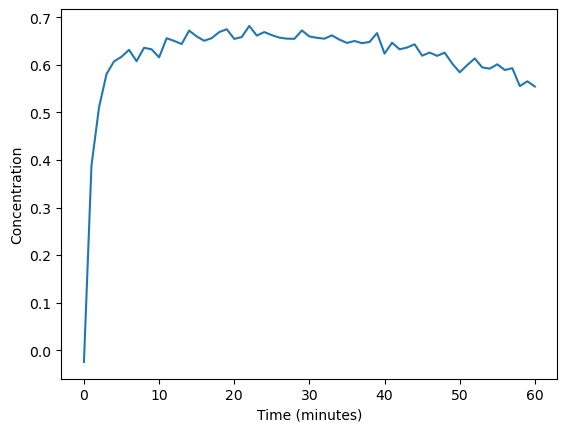

In [19]:
x = 0.17, 0.18, 0.1, 0.1, 0.05, 0
y = np.array([-0.02470415,  0.38816605,  0.51019005,  0.58060101,  0.60741843,
        0.61706499,  0.631839  ,  0.60787538,  0.63607392,  0.6328866 ,
        0.61588247,  0.6561008 ,  0.65054453,  0.64397058,  0.67223243,
        0.65993063,  0.65085875,  0.65634943,  0.66902875,  0.67506762,
        0.6547215 ,  0.65869199,  0.68204272,  0.66170091,  0.66910523,
        0.66268703,  0.6574092 ,  0.65526117,  0.65489365,  0.67255201,
        0.65981424,  0.65704318,  0.65522023,  0.66218455,  0.65318224,
        0.64625276,  0.65033954,  0.6458165 ,  0.64829594,  0.66700549,
        0.62377128,  0.64669723,  0.63288094,  0.63664522,  0.64333323,
        0.61951135,  0.62590015,  0.61912288,  0.62579316,  0.60305238,
        0.58446177,  0.59969874,  0.6136113 ,  0.59473203,  0.59221207,
        0.60127185,  0.58930105,  0.59314068,  0.55544298,  0.56560988,
        0.55449424])
plt.plot(y)
plt.xlabel('Time (minutes)')
plt.ylabel('Concentration')

In [16]:
## Euler Sampling
sample_batch_size = 10000
guidance_scale = 4
num_steps = 10000

sampler = Euler_Maruyama_sampler
 
## Generate samples using the specified sampler.
samples = sampler(model, 
                  x_dim,
                  y,
                  guidance_scale,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  num_steps, 
                  device=device)

100%|█████████████████████████████████████| 10000/10000 [15:45<00:00, 10.57it/s]


In [13]:
# ## ODE sampling
# sample_batch_size = 10000
# guidance_scale = 3.0

# samples = ode_sampler(model,
#                 x_dim,
#                 y,
#                 guidance_scale,
#                 marginal_prob_std_fn,
#                 diffusion_coeff_fn,
#                 batch_size=sample_batch_size, 
#                 atol=error_tolerance, 
#                 rtol=error_tolerance, 
#                 device=device)

In [14]:
# ## PC sampling

# sample_batch_size = 10000
# num_steps = 10000
# guidance_scale = 3.0
# signal_to_noise_ratio = 0.16

# samples = pc_sampler(model, 
#             x_dim,
#             y,
#             guidance_scale,
#             marginal_prob_std_fn,
#             diffusion_coeff_fn,
#             batch_size=sample_batch_size, 
#             num_steps=num_steps, 
#             snr=signal_to_noise_ratio,                
#             device=device)

In [17]:
samples = samples.cpu().data
s = samples.squeeze(1).numpy()
s = np.exp(s)

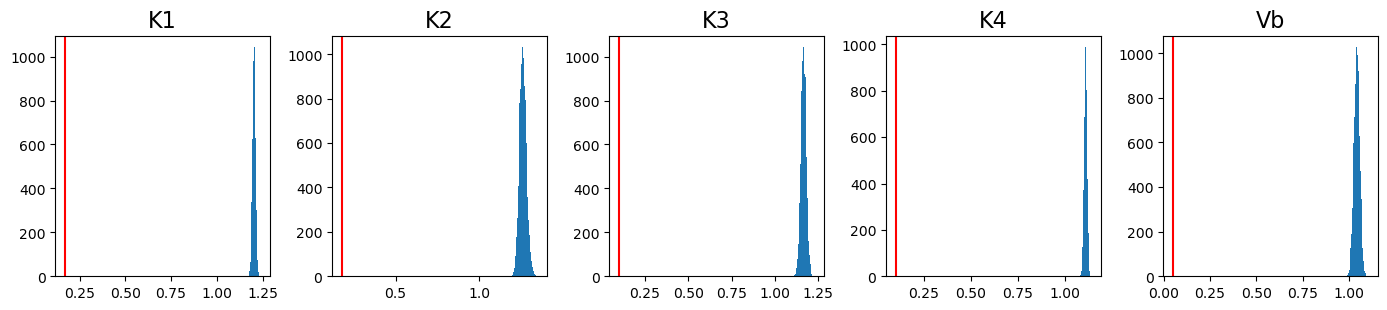

In [18]:
# k1, k2, k3, k4, Vb = get_estimates(samples)

fig, ax = plt.subplots(1, 5, figsize=(14,3))
fig.tight_layout()

ax[0].hist(s[:,0],30)
ax[0].set_title('K1', fontsize = 16)
ax[0].axvline(x[0], color='red')
ax[1].hist(s[:,1],30)
ax[1].set_title('K2', fontsize = 16)
ax[1].axvline(x[1], color='red')
ax[2].hist(s[:,2],30)
ax[2].set_title('K3', fontsize = 16)
ax[2].axvline(x[2], color='red')
ax[3].hist(s[:,3],30)
ax[3].set_title('K4', fontsize = 16)
ax[3].axvline(x[3], color='red')
ax[4].hist(s[:,4],30)
ax[4].set_title('Vb', fontsize = 16)
ax[4].axvline(x[4], color='red')
# fig.savefig('/Users/golfgti/Desktop/Presentation/SBD_noisefree_estimation.png',bbox_inches = 'tight')

In [17]:
## Save estimates
with open('Diffusion_estimates_new.npy', 'wb') as f:
    np.save(f, samples.cpu().data.squeeze(1).numpy())

### testing_result

In [4]:
# Define FID
def fid(array1, array2):
#     # Ensure the arrays are of the same shape
#     if array1.shape != array2.shape:
#         raise ValueError("The input arrays must have the same shape.")

    # Calculate the mean and variance of the two distributions
    mean1, var1 = np.mean(array1), np.var(array1)
    mean2, var2 = np.mean(array2), np.var(array2)

    # Calculate the squared difference of means
    mean_diff = (mean1 - mean2) ** 2

    # Calculate the square root of the product of variances
    var_mean = np.sqrt(var1 * var2)

    # Compute the FID score for 1D arrays
    fid_score = mean_diff + (var1 + var2 - 2 * var_mean)

    return fid_score

In [5]:
# Load MCMC
with open('/Users/golfgti/yu60/yzha0576/KineticModel/MCMC/Results/Gaussian_noise_model/MCMC_estimates_2.npy', 'rb') as f:
    mcmc_estimates = np.load(f)
    
mcmc_estimates = mcmc_estimates[2000001:,:]

*guidance=0.3*

K1: 0.00014539
 K2: 0.00002741
 K3: 0.00001857
 K4: 0.00033557
 Vb: 0.00021729


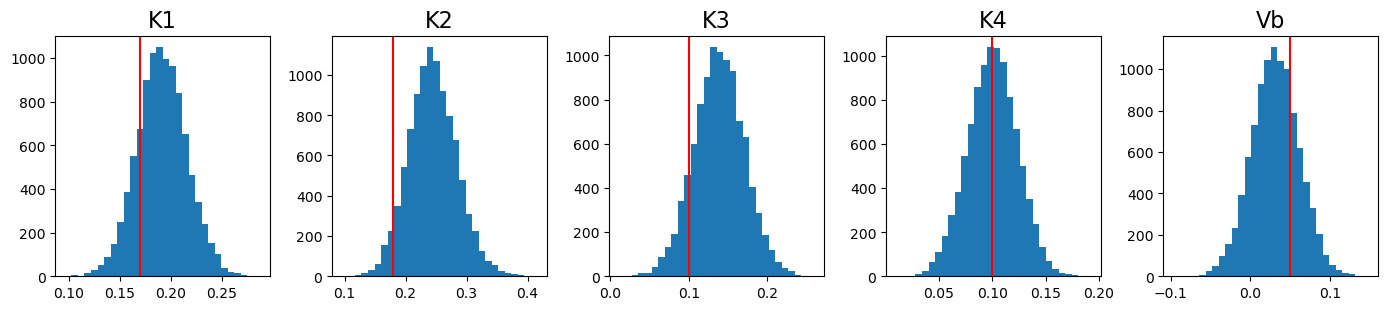

In [56]:
## Load estimates
with open('./testing_result/Diffusion_estimates_1_3e-1.npy', 'rb') as f:
    samples = np.load(f)

fig, ax = plt.subplots(1, 5, figsize=(14,3))
fig.tight_layout()

ax[0].hist(samples[:,0],30)
ax[0].set_title('K1', fontsize = 16)
ax[0].axvline(x[0], color='red')
ax[1].hist(samples[:,1],30)
ax[1].set_title('K2', fontsize = 16)
ax[1].axvline(x[1], color='red')
ax[2].hist(samples[:,2],30)
ax[2].set_title('K3', fontsize = 16)
ax[2].axvline(x[2], color='red')
ax[3].hist(samples[:,3],30)
ax[3].set_title('K4', fontsize = 16)
ax[3].axvline(x[3], color='red')
ax[4].hist(samples[:,4],30)
ax[4].set_title('Vb', fontsize = 16)
ax[4].axvline(x[4], color='red')

print(f'K1: {fid(samples[:,0], mcmc_estimates[:,0]):.8f}\n',
     f'K2: {fid(samples[:,1], mcmc_estimates[:,1]):.8f}\n',
     f'K3: {fid(samples[:,2], mcmc_estimates[:,2]):.8f}\n',
     f'K4: {fid(samples[:,3], mcmc_estimates[:,3]):.8f}\n',
     f'Vb: {fid(samples[:,4], mcmc_estimates[:,4]):.8f}')

*guidance=0.5*

K1: 0.00008636
 K2: 0.00009752
 K3: 0.00000060
 K4: 0.00024279
 Vb: 0.00018973


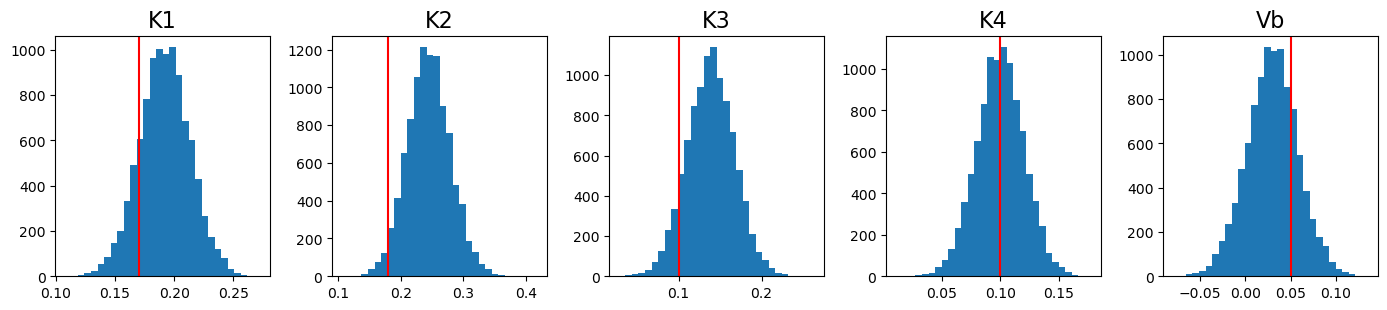

In [57]:
## Load estimates
with open('./testing_result/Diffusion_estimates_1_5e-1.npy', 'rb') as f:
    samples = np.load(f)

fig, ax = plt.subplots(1, 5, figsize=(14,3))
fig.tight_layout()

ax[0].hist(samples[:,0],30)
ax[0].set_title('K1', fontsize = 16)
ax[0].axvline(x[0], color='red')
ax[1].hist(samples[:,1],30)
ax[1].set_title('K2', fontsize = 16)
ax[1].axvline(x[1], color='red')
ax[2].hist(samples[:,2],30)
ax[2].set_title('K3', fontsize = 16)
ax[2].axvline(x[2], color='red')
ax[3].hist(samples[:,3],30)
ax[3].set_title('K4', fontsize = 16)
ax[3].axvline(x[3], color='red')
ax[4].hist(samples[:,4],30)
ax[4].set_title('Vb', fontsize = 16)
ax[4].axvline(x[4], color='red')

print(f'K1: {fid(samples[:,0], mcmc_estimates[:,0]):.8f}\n',
     f'K2: {fid(samples[:,1], mcmc_estimates[:,1]):.8f}\n',
     f'K3: {fid(samples[:,2], mcmc_estimates[:,2]):.8f}\n',
     f'K4: {fid(samples[:,3], mcmc_estimates[:,3]):.8f}\n',
     f'Vb: {fid(samples[:,4], mcmc_estimates[:,4]):.8f}')

*guidance=1*

K1: 0.00003471
 K2: 0.00058053
 K3: 0.00041113
 K4: 0.00010547
 Vb: 0.00014690


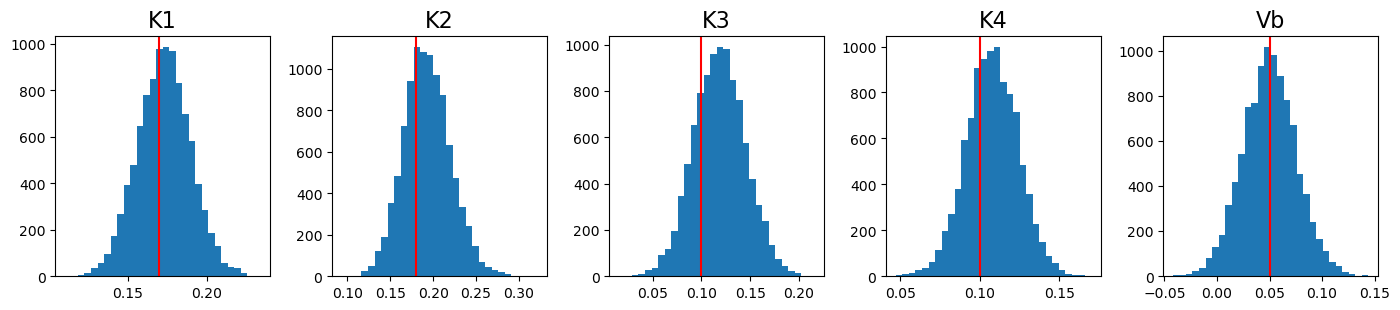

In [20]:
## Load estimates
with open('./testing_result/Diffusion_estimates_51_1.0.npy', 'rb') as f:
    samples = np.load(f)

fig, ax = plt.subplots(1, 5, figsize=(14,3))
fig.tight_layout()

ax[0].hist(samples[:,0],30)
ax[0].set_title('K1', fontsize = 16)
ax[0].axvline(x[0], color='red')
ax[1].hist(samples[:,1],30)
ax[1].set_title('K2', fontsize = 16)
ax[1].axvline(x[1], color='red')
ax[2].hist(samples[:,2],30)
ax[2].set_title('K3', fontsize = 16)
ax[2].axvline(x[2], color='red')
ax[3].hist(samples[:,3],30)
ax[3].set_title('K4', fontsize = 16)
ax[3].axvline(x[3], color='red')
ax[4].hist(samples[:,4],30)
ax[4].set_title('Vb', fontsize = 16)
ax[4].axvline(x[4], color='red')

print(f'K1: {fid(samples[:,0], mcmc_estimates[:,0]):.8f}\n',
     f'K2: {fid(samples[:,1], mcmc_estimates[:,1]):.8f}\n',
     f'K3: {fid(samples[:,2], mcmc_estimates[:,2]):.8f}\n',
     f'K4: {fid(samples[:,3], mcmc_estimates[:,3]):.8f}\n',
     f'Vb: {fid(samples[:,4], mcmc_estimates[:,4]):.8f}')

*guidance=1.2*

K1: 0.00002433
 K2: 0.00035276
 K3: 0.00004685
 K4: 0.00009129
 Vb: 0.00016447


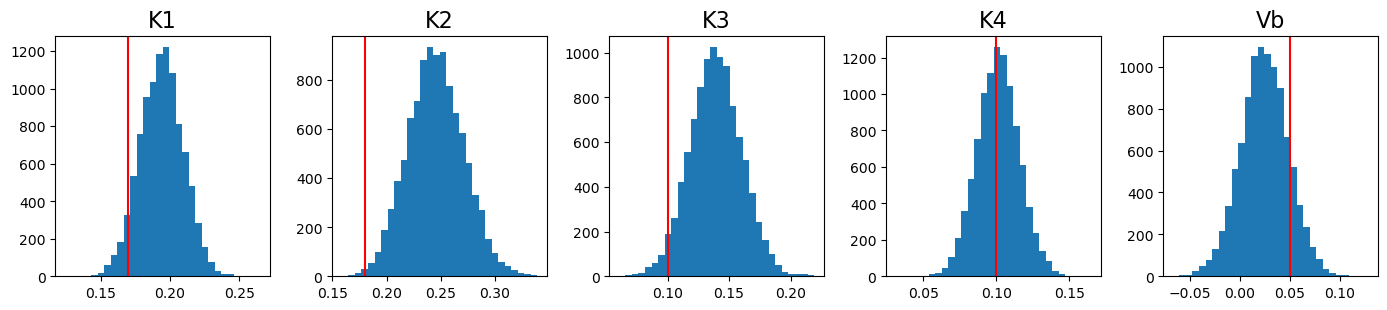

In [93]:
## Load estimates
with open('./testing_result/Diffusion_estimates_1_1.2.npy', 'rb') as f:
    samples = np.load(f)

fig, ax = plt.subplots(1, 5, figsize=(14,3))
fig.tight_layout()

ax[0].hist(samples[:,0],30)
ax[0].set_title('K1', fontsize = 16)
ax[0].axvline(x[0], color='red')
ax[1].hist(samples[:,1],30)
ax[1].set_title('K2', fontsize = 16)
ax[1].axvline(x[1], color='red')
ax[2].hist(samples[:,2],30)
ax[2].set_title('K3', fontsize = 16)
ax[2].axvline(x[2], color='red')
ax[3].hist(samples[:,3],30)
ax[3].set_title('K4', fontsize = 16)
ax[3].axvline(x[3], color='red')
ax[4].hist(samples[:,4],30)
ax[4].set_title('Vb', fontsize = 16)
ax[4].axvline(x[4], color='red')

print(f'K1: {fid(samples[:,0], mcmc_estimates[:,0]):.8f}\n',
     f'K2: {fid(samples[:,1], mcmc_estimates[:,1]):.8f}\n',
     f'K3: {fid(samples[:,2], mcmc_estimates[:,2]):.8f}\n',
     f'K4: {fid(samples[:,3], mcmc_estimates[:,3]):.8f}\n',
     f'Vb: {fid(samples[:,4], mcmc_estimates[:,4]):.8f}')

In [2]:
guidance_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 3.0, 4.0]
fid_array = np.zeros((5,len(guidance_levels)))

for i in range(len(guidance_levels)):
    with open(f'./testing_result/Diffusion_estimates_1_{guidance_levels[i]}.npy', 'rb') as f:
        samples = np.load(f)
    for j in range(5):
        fid_array[j,i] = fid(samples[:,j], mcmc_estimates[:,j])

NameError: name 'fid' is not defined

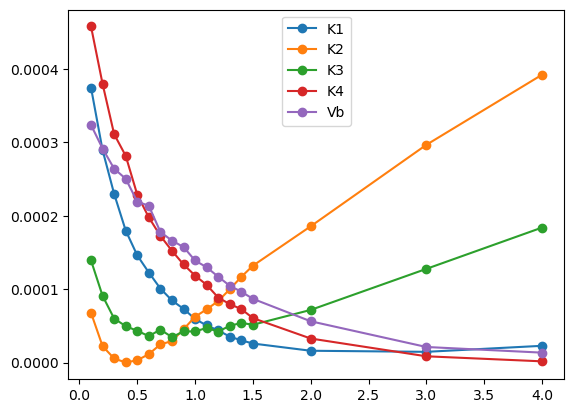

In [10]:
plt.plot(guidance_levels, fid_array[0,:], 'o-', label='K1')
plt.plot(guidance_levels, fid_array[1,:], 'o-', label='K2')
plt.plot(guidance_levels, fid_array[2,:], 'o-', label='K3')
plt.plot(guidance_levels, fid_array[3,:], 'o-', label='K4')
plt.plot(guidance_levels, fid_array[4,:], 'o-', label='Vb')
plt.legend()

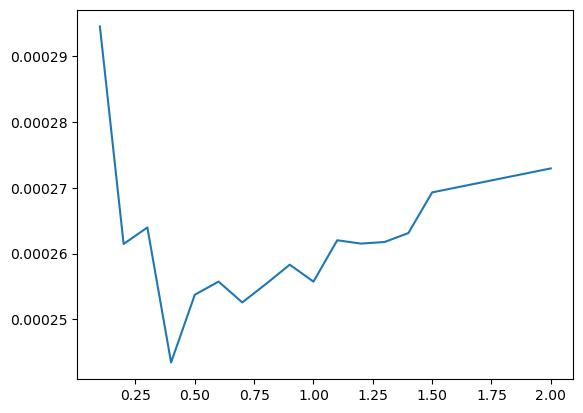

In [16]:
plt.plot(guidance_levels, np.mean(fid_array, axis=0))

In [89]:
np.mean(fid_array[[0,2,3,4],:], axis=0)

array([3.54152753e-04, 2.78859435e-04, 2.34976549e-04, 1.86756550e-04,
       1.58840357e-04, 1.42497849e-04, 1.20402379e-04, 1.08474244e-04,
       9.88490967e-05, 9.07844958e-05, 8.54319093e-05, 8.09977746e-05,
       8.17622913e-05, 7.51022060e-05, 7.89731000e-05, 7.68752460e-05])

### Noise levels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [14]:
with open(f'./testing_result/noiselevel_0.01.npy', 'rb') as f:
    d_1e_2 = np.load(f)
    
with open(f'./testing_result/noiselevel_0.02.npy', 'rb') as f:
    d_2e_2 = np.load(f)
    
with open(f'./testing_result/noiselevel_0.03.npy', 'rb') as f:
    d_3e_2 = np.load(f)
    
with open(f'./testing_result/noiselevel_0.0075.npy', 'rb') as f:
    d_75e_4 = np.load(f)
    
with open(f'./testing_result/noiselevel_0.0125.npy', 'rb') as f:
    d_125e_4 = np.load(f)

In [17]:
with open('../MCMC/noiselevel_0.01.npy', 'rb') as f:
    m_1e_2 = np.load(f)
    
with open('../MCMC/noiselevel_0.02.npy', 'rb') as f:
    m_2e_2 = np.load(f)
    
with open('../MCMC/noiselevel_0.03.npy', 'rb') as f:
    m_3e_2 = np.load(f)
    
with open(f'../MCMC/noiselevel_0.0075.npy', 'rb') as f:
    m_75e_4 = np.load(f)
    
with open(f'../MCMC/noiselevel_0.0125.npy', 'rb') as f:
    m_125e_4 = np.load(f)

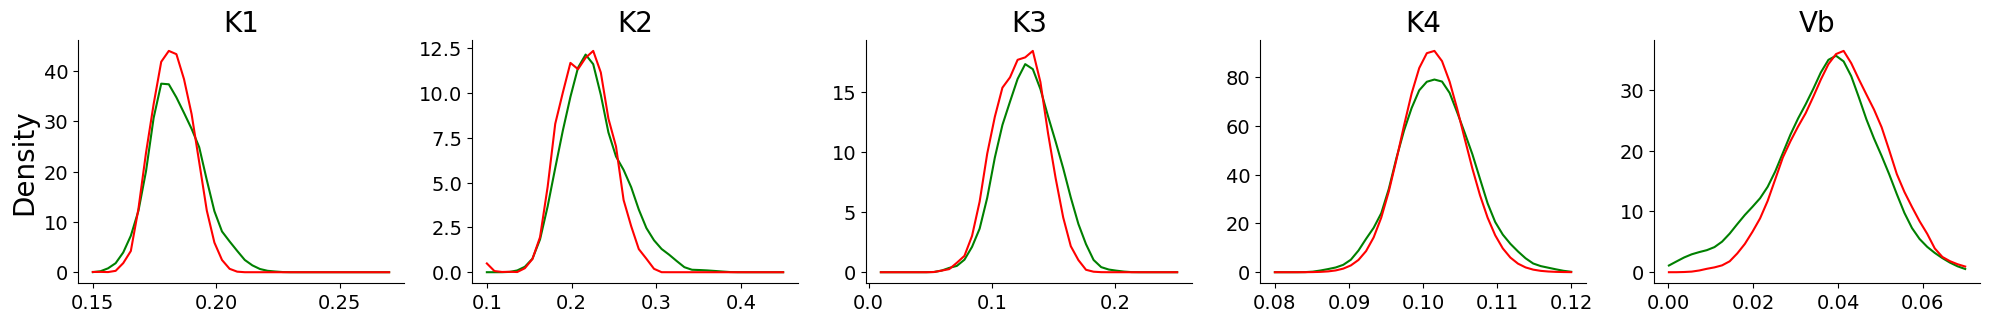

In [18]:
# Title for each plot
Title = ['K1', 'K2','K3','K4','Vb']

ranges = [(0.15, 0.27), (0.1, 0.45), (0.01, 0.25), (0.08, 0.12), (0.0001, 0.07)]

fig, ax = plt.subplots(1, 5, figsize=(20,3.5))
# fig.tight_layout()

for i in range(5):
    x = np.linspace(ranges[i][0], ranges[i][1], 40)

### Diffusion ###
#     d_1e_2_density = stats.gaussian_kde(d_1e_2[:,i])
#     d_2e_2_density = stats.gaussian_kde(d_2e_2[:,i])
#     d_3e_2_density = stats.gaussian_kde(d_3e_2[:,i])
    d_75e_4_density = stats.gaussian_kde(d_75e_4[:,i])
#     d_125e_4_density = stats.gaussian_kde(d_125e_4[:,i])

#     ax[i].plot(x, d_1e_2_density(x), color = 'green')
#     ax[i].plot(x, d_2e_2_density(x), color = 'green')
#     ax[i].plot(x, d_3e_2_density(x), color = 'green')
    ax[i].plot(x, d_75e_4_density(x), color = 'green')
#     ax[i].plot(x, d_125e_4_density(x), color = 'green')

### MCMC ###
#     m_1e_2_density = stats.gaussian_kde(m_1e_2[:,i])
#     m_2e_2_density = stats.gaussian_kde(m_2e_2[:,i])
#     m_3e_2_density = stats.gaussian_kde(m_3e_2[:,i])
    m_75e_4_density = stats.gaussian_kde(m_75e_4[:,i])
#     m_125e_4_density = stats.gaussian_kde(m_125e_4[:,i])
      
#     ax[i].plot(x, m_1e_2_density(x), color = 'red')
#     ax[i].plot(x, m_2e_2_density(x), color = 'green')
#     ax[i].plot(x, m_3e_2_density(x), color = 'red')
    ax[i].plot(x, m_75e_4_density(x), color = 'red')
#     ax[i].plot(x, m_125e_4_density(x), color = 'green')

    ax[i].set_title(f'{Title[i]}', fontsize = 20)
    
    if i == 0:
        ax[i].set_ylabel('Density', fontsize=20)
        
         
    # Remove top and right spines (borders)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    # Change the font size of the labels
    ax[i].tick_params(axis='x', labelsize=14)  # Adjust font size for x-axis labels
    ax[i].tick_params(axis='y', labelsize=14)  # Adjust font size for y-axis labels


# Create a single legend for the whole figure
# labels = ['MCMC', 'CVAE', 'CVAE-Feedback', 'SB-Diffusion']
# fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4, fontsize=16)
# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the bottom
# fig.savefig('R1 simulation study nontrivial K4 example.png', format='png', dpi=300, bbox_inches='tight')
plt.show()